In [1]:
import pandas as pd
import numpy as np
import sklearn
from scipy import stats
from statsmodels.sandbox.stats.multicomp import multipletests 
import scipy
import seaborn
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge

%pylab inline
from matplotlib.colors import ListedColormap

Populating the interactive namespace from numpy and matplotlib


Описание колонок в файле:
 
timestamp - календарное время снятия показаний работы сервиса в формате time_t.

conns - текущее количество соединений клиентов.

count - полное количество обработанных запросов клиентов с момента старта сервиса.

read_bytes_total - полное количество байт, прочитанных сервисом с момента старта.

latency_ms_sum - полное время обработки всех запросов клиентов с момента старта сервиса.


In [2]:
data = pd.read_csv('predict.csv', sep = ',', header = 0)

data.head()


,timestamp,count,conns,read_bytes_total,latency_ms_sum
0,1564650000,88967916.0,349.0,1.081355e+13,509146850.3
1,1564650300,88989154.0,336.0,1.081708e+13,509262088.5
2,1564650600,89004769.0,333.0,1.081963e+13,509341201.7
3,1564650900,89020289.0,330.0,1.082215e+13,509415425.9
4,1564651200,89026526.0,311.0,1.082481e+13,509483841.9


In [3]:
print(data.isna().sum())
print("shape = ", data.shape)

timestamp             0
count               362
conns               362
read_bytes_total    362
latency_ms_sum      362
dtype: int64
shape =  (8352, 5)


По сравнению с колличеством данных количество Nan мало, а значит мы можем просто их удалить

In [4]:
data = data.dropna()
X = data[data.columns.drop('latency_ms_sum')]
Y = data['latency_ms_sum']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001AFD5976608>,
      dtype=object)

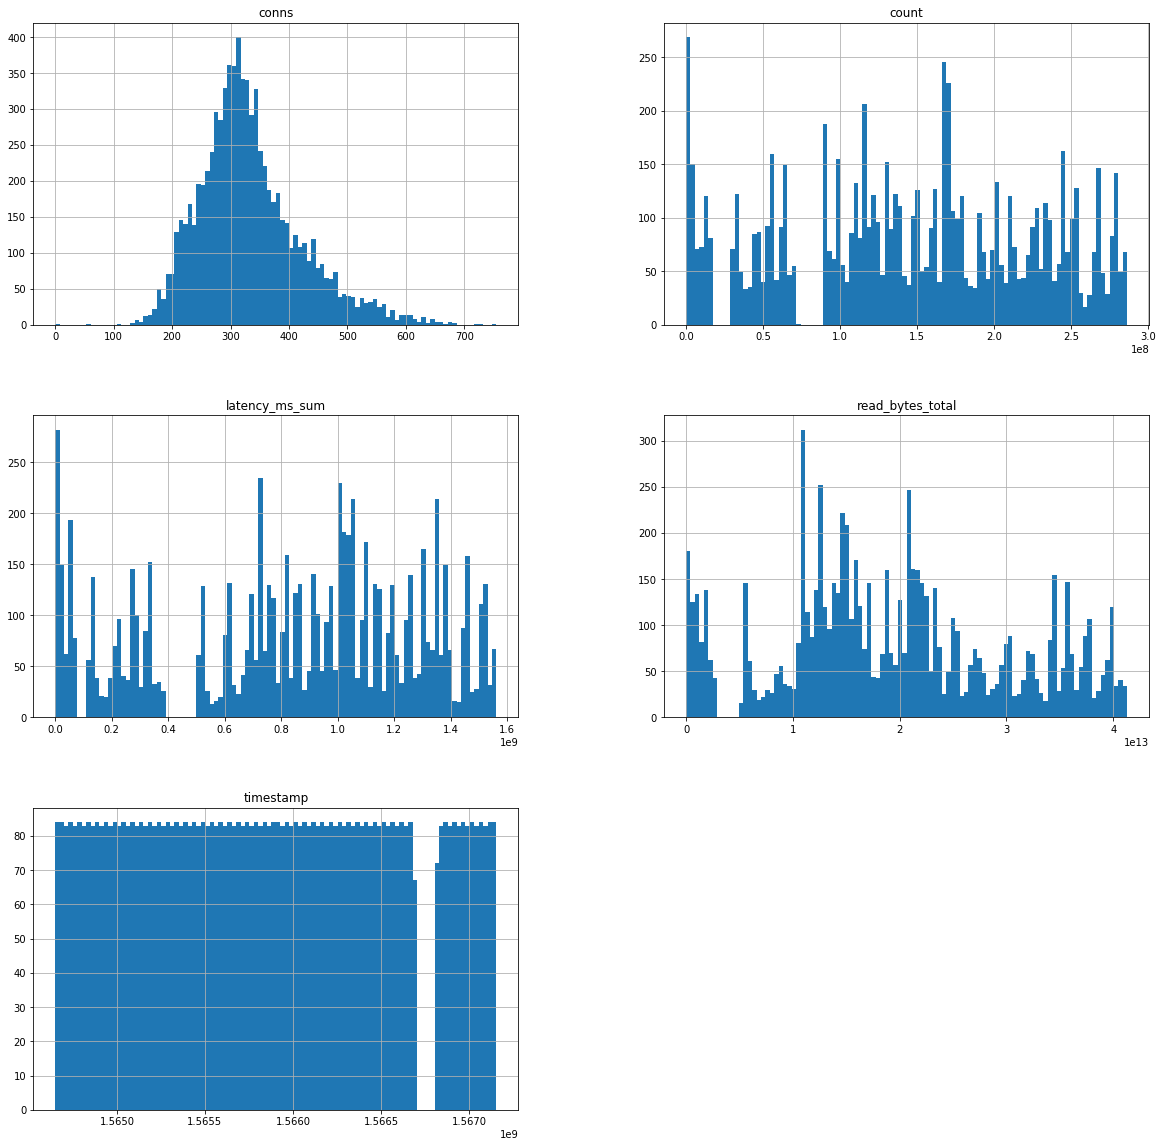

In [5]:
#Отрисуем данные  в нашем датасете
data[data.columns].hist(figsize = (20, 20), bins=100)

Визуализация позволяет сделать предположение лишь о том, что conns распределено нормально, что вообще говоря логиччно учитывая, что conns это колличество клиентов.

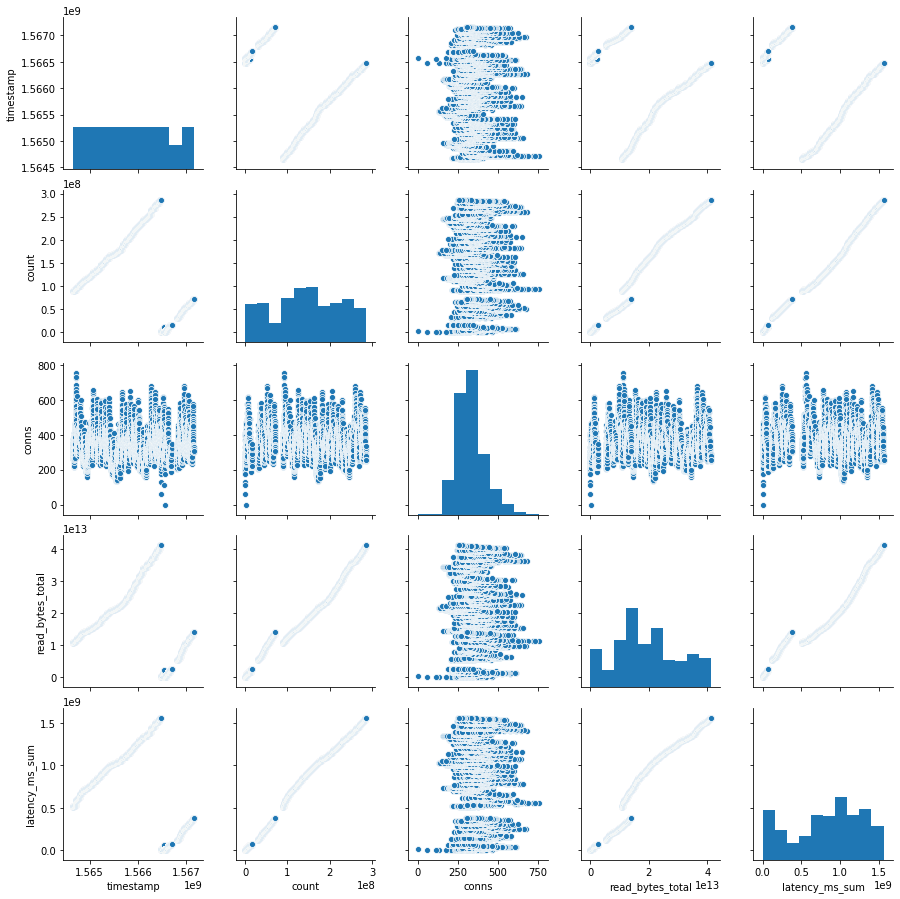

In [5]:
#построим график попарных зависимостех признаков
seaborn.pairplot(data, diag_kind="hist")


Из графико можно предположить существование линейная зависимость целевого признака  $\text{latency_ms_sum}$ от $count, \text{read_bytes_total}$.

Зависимость от $timestamp$ представляет собой разрывную  функцию, которая является объединением двух линейных..

При этом следует учесть что сами эти признаки довольно хорошо корелиируют друг с другом, а значит  между ними может быть линейная зависимость.

Во что охотно вериться учитывая, что обычно число $count$ довольно большое, а значит  может выполняться

$\text{read_bytes_total} \approx mean(\text{read_bytes_total}) \cdot count$.


# 1.       Построить одну или несколько моделей, предсказывающих следующее значение целевой метрики latency_ms_sum в зависимости от предыдущих значений всех остальных метрик.
# 2.      Построить на одном графике реальное значение метрики latency_ms_sum и предсказанное.


## Давайте начнём с линейной модели

##### Посмотрим на корреляции признаков, чтобы узнать, не нужно ли удалять какие-то признаки перед (гипотетическим) построением модели. 



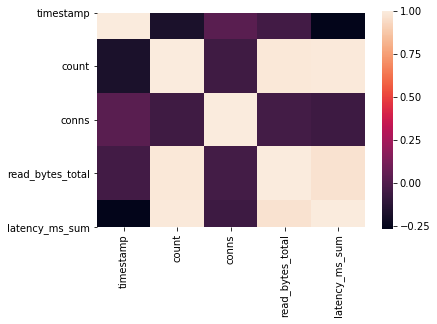

In [6]:
seaborn.heatmap(data[data.columns].corr(), square=True)

In [7]:
data[data.columns].corr()

,timestamp,count,conns,read_bytes_total,latency_ms_sum
timestamp,1.000000,-0.173507,0.027644,-0.043517,-0.265835
count,-0.173507,1.000000,-0.053857,0.986806,0.994178
conns,0.027644,-0.053857,1.000000,-0.043292,-0.061332
read_bytes_total,-0.043517,0.986806,-0.043292,1.000000,0.967070
latency_ms_sum,-0.265835,0.994178,-0.061332,0.967070,1.000000


Предположение оказалось верным и  дейстивительно count и read_bytes_total кореллируют друг с другом.

Чтобы  коэффиценты линейной реграсии имели адекватный масштаб, давайте нормализуем наши данные

сразу создав класс, чтобы иметь возможность вернуться к исходному масштабу(но мы его применять не будем)

In [8]:
class normalize_to_ordinory:
    def __init__(self,data):
        self.const_a = data.max() - data_min
        self.const_b = data.mean()
    def ans(self, X):
        return X* self.const_a+ self.const_b
n_data = ((data -data.mean())/(data.max() - data.min()))
X_n = n_data[data.columns.drop('latency_ms_sum')]
Y_n = n_data['latency_ms_sum']
n_data.head()

,timestamp,count,conns,read_bytes_total,latency_ms_sum
0,-0.484608,-0.194782,0.021687,-0.207900,-0.206213
1,-0.484489,-0.194708,0.004469,-0.207815,-0.206139
2,-0.484369,-0.194653,0.000495,-0.207753,-0.206089
3,-0.484249,-0.194599,-0.003478,-0.207692,-0.206041
4,-0.484129,-0.194577,-0.028644,-0.207628,-0.205997


визуальный анализ данных, говорит о том, что нам требуется точность хотя бы до 5 знака

In [132]:
def lin_models(clf, X, Y, data):
    train_data, test_data, train_labels, test_labels = model_selection.train_test_split(X, Y, test_size = 0.2,random_state = 0)
    clf.fit(train_data, train_labels)
    for i, j in zip(X.columns, clf.coef_):
        print(i, j)
    predict =  clf.predict(test_data)
    mse = sklearn.metrics.mean_squared_error(predict, test_labels)
    k = range(300)
    plt.plot(k, np.array(test_labels)[k], label = "test Real Data range 300")
    plt.plot(k, clf.predict(test_data)[k], label = "test Predict range 300")
    plt.legend()
    print("MSE = ",mse)
    return float(mse)
    

### линейная регрессия без параметров

timestamp -0.07489732285246058
count 1.178734807133093
conns -0.011388375877802176
read_bytes_total -0.19008916567907627
MSE =  0.00020578393065885875


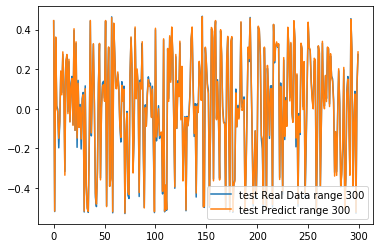

In [133]:
temp = LinearRegression()
t1 = lin_models(temp, X_n, Y_n, data)

#### применим L1 регуляризацию

timestamp -0.0
count 0.0
conns -0.0
read_bytes_total 0.0
MSE =  0.084665591240614


0.084665591240614

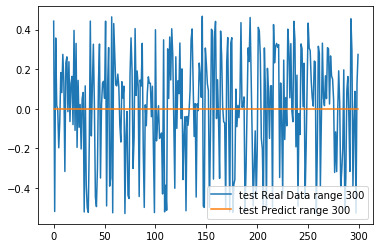

In [134]:
temp = Lasso()
lin_models(temp, X_n, Y_n, data)

Все признаки моделью были оценены как неинформотивные

#### применим L2 регуляризацию

timestamp -0.10072546176440658
count 0.9766392862749295
conns -0.014996144618626243
read_bytes_total 0.024070139920060636
MSE =  0.00024330234414327655


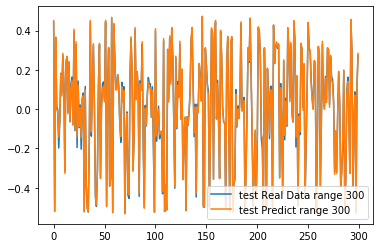

In [135]:
temp = Ridge()
b = lin_models(temp, X_n, Y_n, data)

Давайте попробуем объяснить такие плохие результаты линейной регресии ошибка уже в 4 знаке после запятой

Text(0, 0.5, 'latency_ms_sum')

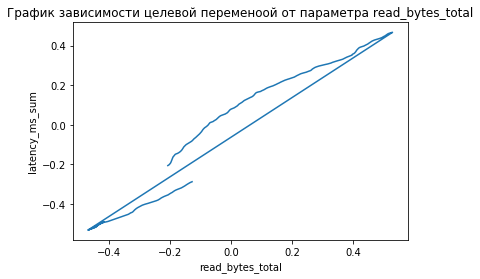

In [136]:
plt.plot(X_n.read_bytes_total.values,Y_n)
plt.title("График зависимости целевой переменоой от параметра read_bytes_total"); plt.xlabel('read_bytes_total'); plt.ylabel('latency_ms_sum')

Мы можем увидеть, что одному значению read_bytes_total, соответсвует совершенно иное значение latency_ms_sum

## Решающие дерево

In [137]:
%%time
#решающее дерево легко переобучается, поэтому будем с этим бороться
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
best_model = DecisionTreeRegressor()
best_score = 100000
er_score = []
# будем менять параметр глубины дерева
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_n, Y_n, test_size = 0.2,random_state = 0)
for deeph in range(100, 7000, 100):

    regressor = DecisionTreeRegressor(max_depth = deeph, random_state=0)
    score = cross_val_score(regressor, X_train, y_train, cv=5)
    score = sum(score)/ len(score)
    if(score < best_score):
        best_score = score
        regressor.fit(X_train, y_train)
        best_model = regressor
        er_score.append(sklearn.metrics.mean_squared_error(y_test, regressor.predict(X_test)))
        



Wall time: 19.5 s


In [138]:
best_model

DecisionTreeRegressor(criterion='mse', max_depth=100, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=0, splitter='best')

In [106]:
print("DecisionTree errror = ",er_score[-1])

DecisionTree errror =  1.5026909084081352e-07


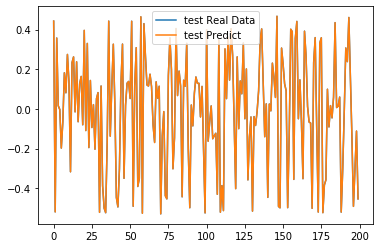

In [112]:
#на большом диапазоне данные сливаются в "кашу", поэтому давате отрисуем для 200
x = range(200)
plt.plot(x,np.array(y_test)[x], label = "test Real Data")
plt.plot(x, best_model.predict(X_test)[x], label = "test Predict")
plt.legend()

## Градиентный бустинг

In [16]:
%%time
import xgboost as xgb
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_n, Y_n, test_size = 0.2,random_state = 0)
xgb_scoring = []
models = []
n_trees = [50, 100, 150, 200, 250, 300]
for n_tree in range(50, 1000, 50):
    for depth in range(1, 50):
        estimator = xgb.XGBRegressor(learning_rate=0.1, max_depth=depth, n_estimators= n_tree, min_child_weight=3)
        estimator.fit(X_train, y_train)

        score = sklearn.metrics.mean_squared_error(y_test, estimator.predict(X_test))
        if(len(xgb_scoring) == 0 or score < min(xgb_scoring)):
            models.append(estimator)
        xgb_scoring.append(score)

Wall time: 22min 24s


In [113]:
print("XGBoost errror = ",(min(xgb_scoring)))

XGBoost errror =  3.8054716691794283e-07


In [30]:
a = models[-1].predict(X_test)
a

array([ 0.44271123, -0.5195887 ,  0.3579672 , ...,  0.13967654,
       -0.53132915, -0.36087084], dtype=float32)

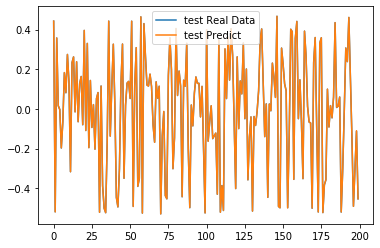

In [56]:
#на большом диапазоне данные сливаются в "кашу", поэтому давате отрисуем для 200
x = range(200)
plt.plot(x,np.array(y_test)[x], label = "test Real Data")
plt.plot(x, a[x], label = "test Predict")
plt.legend()

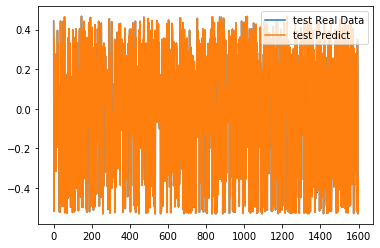

In [37]:
x = range(a.shape[0])
plt.plot(x,np.array(y_test)[x], label = "test Real Data")
plt.plot(x, a[x], label = "test Predict")
plt.legend()

### Решающие дерево показало лучший результат, поэтому дальше будем работать с ним

## 3.       Построить график ошибки предсказаний в зависимости от календарного времени.


In [143]:
%%time
ax = data.timestamp.values
ay = []
for i in n_data.timestamp.values:
    t_data = n_data[n_data.timestamp == i]
    x_n = t_data[data.columns.drop('latency_ms_sum')]
    y_n = t_data['latency_ms_sum']
    ay.append(sklearn.metrics.mean_squared_error(y_n, best_model.predict(x_n)))

Wall time: 1min 3s


Text(0, 0.5, 'MSE')

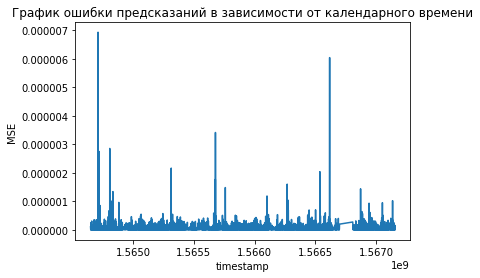

In [144]:
plt.plot(ax,ay)
plt.title("График ошибки предсказаний в зависимости от календарного времени"); plt.xlabel('timestamp'); plt.ylabel('MSE')

на графике видно примерно 13 аномальных скачков, скорее всего именно в этих местах и находятся наши аномальные latency_ms_sum

# 4.       Найти все интервалы времени аномального поведения сервиса и отобразить их на графике метрики latency_ms_sum в зависимости от календарного времени.


Text(0, 0.5, 'latency_ms_sum')

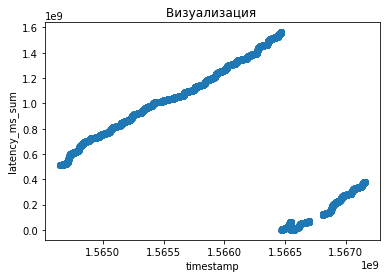

In [146]:
plt.scatter(data.timestamp,data.latency_ms_sum)
plt.title("Визуализация "); plt.xlabel('timestamp'); plt.ylabel('latency_ms_sum')

Из визулизации сложно понять какие данные являются аномальными, можно лишь сделать вывод о том, что все точки можно разбить на 3 класса.

Причиной изменения latency_ms_sum может служить как падения нагрузки на сервера так и, например, обновление "железа" на котором они работают.

Применим TSNE визуализацию

In [158]:
%%time
from sklearn import manifold
tsne = manifold.TSNE(n_components = 2, init = 'pca', random_state = 0)
data_2d_tsne = tsne.fit_transform(X)


NameError: name 'labels' is not defined

<Figure size 720x432 with 0 Axes>

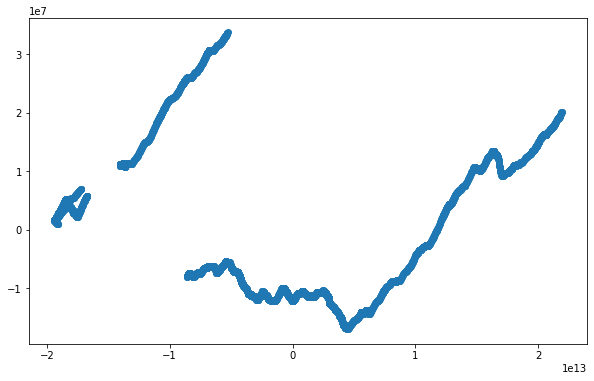

In [159]:
pylab.figure(figsize = (10, 6))
pylab.scatter(data_2d_tsne[:, 0], data_2d_tsne[:, 1])

Опять видим 3 класса

In [ ]:
latency_ms_sum = data['latency_ms_sum'].values
 
# Для совместимости со SciPy 
latency_ms_sum = latency_ms_sum.reshape(-1, 1)
latency_ms_sum = latency_ms_sum.astype('float64')
from scipy import cluster
from scipy.cluster.vq import kmeans
    
# Передаём данные и число кластеров в kmeans()
centroids, avg_distance = kmeans(latency_ms_sum, 2)
groups, cdist = cluster.vq.vq(latency_ms_sum, centroids)

# Рисуем график
plt.scatter(latency_ms_sum, np.arange(0, len(latency_ms_sum)), c=groups)
plt.xlabel('latency_ms_sum')
plt.ylabel('Indices')
plt.show()


In [198]:
gr1 =[]
t1 = []
gr2 = []
t2 = []
gr3 = []
t_vrem = data.timestamp.values
t3 = []
for i in range(len(t_vrem)):
    if groups[i] ==1:
        gr1.append(latency_ms_sum[i])
        t1.append(t_vrem[i])
    if groups[i] ==2:
        gr2.append(latency_ms_sum[i])
        t2.append(t_vrem[i])
    if groups[i] ==0:
        gr3.append(latency_ms_sum[i])
        t3.append(t_vrem[i])

Text(0, 0.5, 'latency_ms_sum')

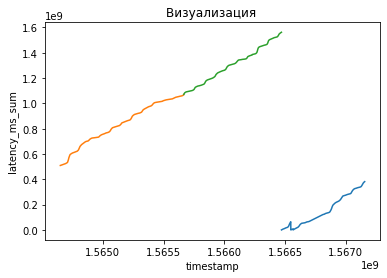

In [199]:
plt.plot(t1,gr1, label = "group1")
plt.plot(t2,gr2, label = "group2")
plt.plot(t3,gr3, label = "group3")
plt.title("Визуализация "); plt.xlabel('timestamp'); plt.ylabel('latency_ms_sum')